# **ANALISI VARIE**

In [1]:
list_N_atoms = [108, 256, 500, 864, 1372, 2048]
def build_nomefile(N_atoms):
    #return f"../../../data/pos-fcc100-minime/C_s=5e-4~F_t=5e-4~max_s=50k/fcc100a{N_atoms}_1.txt"
    return f"../../../data/pos-fcc100-random/fcc100a{N_atoms}.txt"

### Importazioni

In [2]:
from CMS.MolecularDynamics.CrystalStructure import CrystalStructure as Crystal
from CMS.MolecularDynamics.CrystalDynamics import CrystalDynamics

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import time

### Dati

In [3]:
# temperature da studiare
temperature = [50, 300, 850] # in K, cerco una temperatura finale ~850 K (rescale velocità)

# massa atomica dell'atomo considerato (argento)
silver_mass = 108

# time step ottimale per ciascuna temperatura MA TROVATO PER 256 ATOMI
time_step = {
    50: 19e-15, # 5000 step -> 100 ps
    300: 6e-15, # 5000 step -> 30 ps
    850: 4e-15  # 5000 step -> 20 ps
}

# scelgo di simulare per un numero di step fisso
n_steps = 5000

# tempo di termalizzazione (ogni valore precedente va buttato)
t_th = 3e-12 

result = {}
simulation_time = {}

### Simulazione

In [4]:
R_V = 5.0
R_C = 4.5
R_P = 4.2

In [5]:
for T in temperature:
    print(f"🚀 Avvio simulazione con T={T} K")
    result[T] = {}
    simulation_time[T] = {}
    for N in list_N_atoms:
        print(f"• N={N} atomi")
        start_time = time.time()
        # Inizializzo il cristallo dal file minimizzato con steepest-descent
        filename = build_nomefile(N)
        cristallo = Crystal.from_file(filename)
        # Setto il raggio di cutoff E la giunzione polinomiale
        cristallo.set_R_C(R_C)
        cristallo.set_R_P(R_P)
        cristallo.set_R_V(R_V)
        # condizioni al contorno periodiche (vanno settate DOPO R_C)
        # cristallo.set_pbc(pbc)

        # Raccolgo le energie medie e le dev std
        simulazione = CrystalDynamics(cristallo, 
                            atomic_mass=silver_mass, 
                            dt=time_step[T], 
                            temp_ini=T, 
                            atom_tracker=None, 
                            xyz_writer=None)  
        simulazione.set_seed(12316543)

        # stavolta output True per visualizzare con ovito
        result[T][N] = simulazione.run_dynamics(n_steps=n_steps, 
                                            t_th=t_th,
                                            rescale_velocity=True,
                                            debug=False)
        
        end_time = time.time()
        simulation_time[T][N] = end_time - start_time

🚀 Avvio simulazione con T=50 K
• N=108 atomi
• N=256 atomi
• N=500 atomi
• N=864 atomi
• N=1372 atomi
• N=2048 atomi
🚀 Avvio simulazione con T=300 K
• N=108 atomi
• N=256 atomi
• N=500 atomi
• N=864 atomi
• N=1372 atomi
• N=2048 atomi
🚀 Avvio simulazione con T=850 K
• N=108 atomi
• N=256 atomi
• N=500 atomi
• N=864 atomi
• N=1372 atomi
• N=2048 atomi


---

## **Analisi**

## Plot $\delta E / \langle E \rangle$ v $N$

Dal grafico $\delta E / \langle E \rangle$ v $N$ mi aspetto di vedere un comportamento come 1/√N. La verlet cage non dovrebbe influire, ma plotto le curve per entrambi i casi.

In [6]:
def radice (N, A):
    return A / np.sqrt(N)

In [7]:
rapporti = {T: [result[T][N].std_E_tot / abs(result[T][N].mean_E_tot) for N in list_N_atoms] for T in temperature}

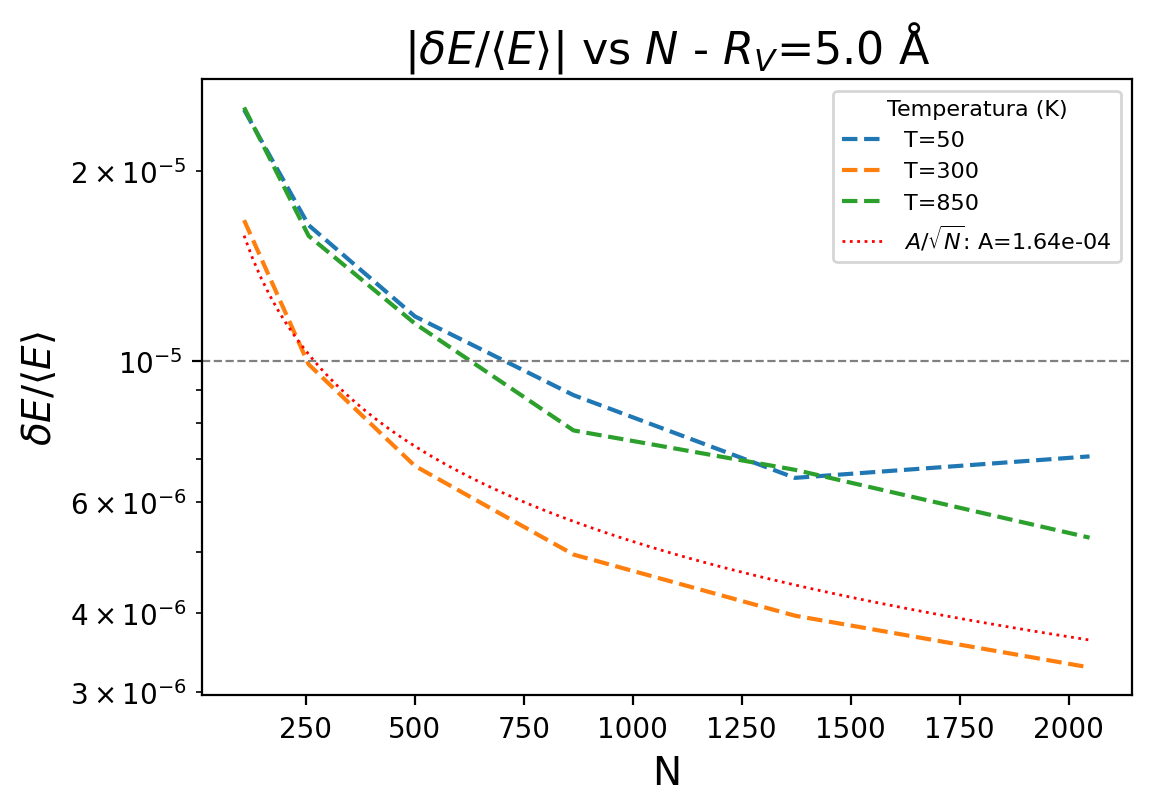

In [8]:
plt.figure(figsize=(6,4), dpi=200)

# plotto #
for T in temperature:
    plt.plot(list_N_atoms, rapporti[T], 
             linestyle='--', linewidth=1.5, label=f'T={T}')

# fitto con 1/√N #
p0 = [-4.74E-5]  # valori iniziali per A
low = [-np.inf]  # limiti inferiori per A
upp = [np.inf]  # limiti superiori per A
popt, _ = curve_fit(radice, list_N_atoms, rapporti[300], p0=p0, bounds=(low, upp))
x_fit = np.linspace(min(list_N_atoms), max(list_N_atoms), 100)
y_fit = radice(x_fit, *popt)
plt.plot(x_fit, y_fit, color='red', linestyle=':', linewidth=1, label=f'$A/\\sqrt{{N}}$: A={popt[0]:.2e}')

# opzioni #
plt.axhline(y=1E-05, color='grey', linewidth=0.8, linestyle='--')
plt.xlabel('N', fontsize=14)
plt.ylabel(r'$\delta E/\langle E \rangle$', fontsize=14)
plt.yscale('log')
leg = plt.legend(title='Temperatura (K)', fontsize=8, title_fontsize=8)
#leg.get_title().set_fontweight('bold')
plt.title(rf"$|\delta E/\langle E \rangle|$ vs $N$ - $R_V$={R_V} Å", fontsize=16)
plt.show()